<a href="https://colab.research.google.com/github/hristogwivanov/computer-vision-cats-vs-dogs/blob/main/Task1_01_dogs_vs_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install kaggle

In [2]:
import os
from google.colab import userdata

os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

print("KAGGLE_USERNAME and KAGGLE_KEY environment variables have been set.")

KAGGLE_USERNAME and KAGGLE_KEY environment variables have been set.


In [3]:
# Създаване на папка за тестовите данни
if not os.path.exists('dogs_vs_cats'):
    os.makedirs('dogs_vs_cats')
    print("Created directory: dogs_vs_cats")

# Изтегляне на тестовите данни
print("Downloading 'Dogs vs. Cats' dataset...")
!kaggle datasets download -d biaiscience/dogs-vs-cats -p dogs_vs_cats

Dataset URL: https://www.kaggle.com/datasets/biaiscience/dogs-vs-cats
License(s): DbCL-1.0
dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import shutil

# Почистване на папките с тестовите снимки, ако съществуват предишни такива
clean_dirs = [
    'dogs_vs_cats/train',
    'dogs_vs_cats/test',
    'dogs_vs_cats/train_resized'
]

print("Cleaning up previous unzipped directories...")
for directory in clean_dirs:
    if os.path.exists(directory):
        shutil.rmtree(directory)
        print(f"Removed existing directory: {directory}")
    else:
        print(f"Directory did not exist, no action needed: {directory}")
print("Cleanup complete.")

Cleaning up previous unzipped directories...
Removed existing directory: dogs_vs_cats/train
Removed existing directory: dogs_vs_cats/test
Directory did not exist, no action needed: dogs_vs_cats/train_resized
Cleanup complete.


In [5]:
print("Unzipping 'dogs-vs-cats.zip'...")
!unzip -q dogs_vs_cats/dogs-vs-cats.zip -d dogs_vs_cats/
print("Dataset unzipping complete.")

Unzipping 'dogs-vs-cats.zip'...
Dataset unzipping complete.


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt

# --- 1. Подготовка на данните ---

# Дефиниране на трансформациите за изображенията
# Добавяме и лека аугментация (RandomHorizontalFlip, RandomRotation) за по-добро обобщение
image_transforms = transforms.Compose([
    transforms.Resize((128, 128)),            # Оразмеряване до 128x128 пиксела
    transforms.RandomHorizontalFlip(),        # Случайно хоризонтално обръщане
    transforms.RandomRotation(10),            # Случайно завъртане до 10 градуса
    transforms.ToTensor(),                    # Преобразуване в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Нормализиране
])

# Дефиниране на клас за Dataset-а
class DogsAndCatsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        # Зареждане на файловете от директорията
        for img_name in os.listdir(root_dir):
            if img_name.endswith('.jpg'):
                self.image_paths.append(os.path.join(root_dir, img_name))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            return None # Пропускане при грешка с файла

        # Етикет: 0 за котка ('cat'), 1 за куче
        label = 0 if 'cat' in os.path.basename(img_path) else 1

        if self.transform:
            image = self.transform(image)
        return image, label

# Създаване на пълния Dataset
full_dataset = DogsAndCatsDataset(root_dir='dogs_vs_cats/train/train', transform=image_transforms)

# Използване на подмножество от 10,000 изображения за по-бързо обучение
subset_indices = range(10000)
subset_dataset = Subset(full_dataset, subset_indices)

# Разделяне на данните: 80% за обучение (8000), 20% за валидация (2000)
train_size = 8000
val_size = 2000
train_dataset, val_dataset = random_split(subset_dataset, [train_size, val_size])

# Създаване на DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Данни за обучение: {len(train_dataset)}")
print(f"Данни за валидация: {len(val_dataset)}")

Данни за обучение: 8000
Данни за валидация: 2000


In [7]:
# --- 2. Дефиниране на Модела ---

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Първи конволюционен слой: 3 входящи канала (RGB), 32 изходящи, ядро 3x3
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        # Втори конволюционен слой: 32 входящи, 64 изходящи
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Pooling слой за намаляване на размера наполовина
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Dropout за предотвратяване на overfitting
        self.dropout = nn.Dropout(0.5)

        # Напълно свързани слоеве (Fully Connected)
        # Вход: 128x128 -> (pool) -> 64x64 -> (pool) -> 32x32
        # Размер на Flatten слоя: 64 канала * 32 * 32
        self.fc1 = nn.Linear(64 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 2) # 2 изхода: котка или куче

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32) # Изравняване (Flatten)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)          # Прилагане на Dropout
        x = self.fc2(x)
        return x

# Инициализиране на устройство (GPU или CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Използвано устройство: {device}")

# Създаване на инстанция на модела и преместване на устройството
model = SimpleCNN().to(device)

# Дефиниране на Loss функция и Оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Използвано устройство: cuda


In [8]:
# --- 3. Обучение на Модела ---

num_epochs = 10
train_losses = []
val_accuracies = []

print("Започване на обучението...")

for epoch in range(num_epochs):
    # --- Фаза на обучение ---
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        if images is None: continue # Пропускане на дефектни изображения

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()           # Зануляване на градиентите
        outputs = model(images)         # Forward pass
        loss = criterion(outputs, labels) # Изчисляване на загубата
        loss.backward()                 # Backward pass
        optimizer.step()                # Обновяване на теглата

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- Фаза на валидация ---
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

print("Обучението завърши.")

Започване на обучението...
Epoch [1/10], Loss: 0.7386, Accuracy: 62.05%
Epoch [2/10], Loss: 0.6166, Accuracy: 66.25%
Epoch [3/10], Loss: 0.5839, Accuracy: 68.25%
Epoch [4/10], Loss: 0.5703, Accuracy: 69.40%
Epoch [5/10], Loss: 0.5447, Accuracy: 70.10%
Epoch [6/10], Loss: 0.5310, Accuracy: 69.95%
Epoch [7/10], Loss: 0.5174, Accuracy: 72.20%
Epoch [8/10], Loss: 0.5053, Accuracy: 72.95%
Epoch [9/10], Loss: 0.4981, Accuracy: 72.80%
Epoch [10/10], Loss: 0.4842, Accuracy: 73.50%
Обучението завърши.


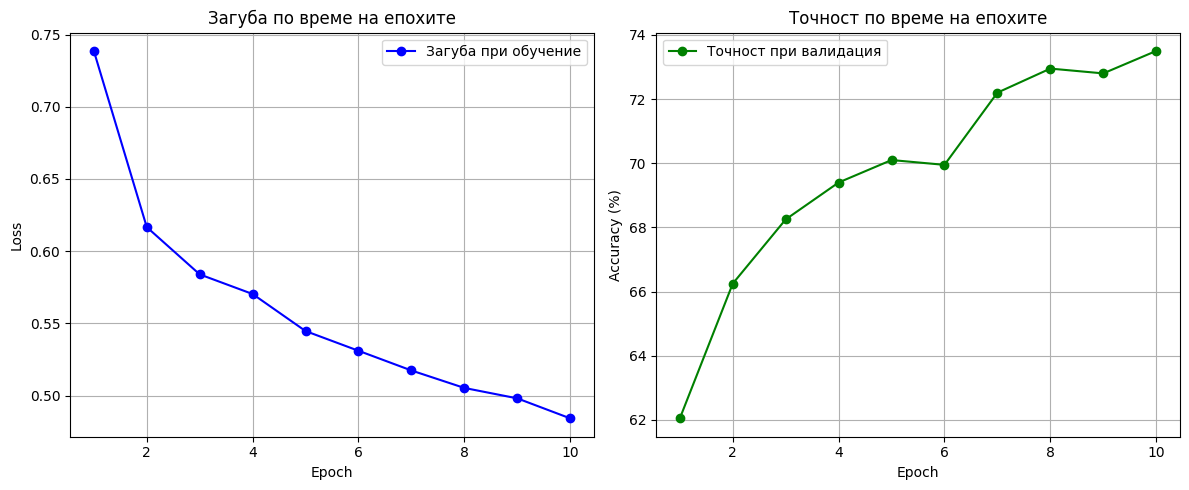

Финална точност на валидационния сет: 73.50%


In [9]:
# --- 4. Визуализация на резултатите ---

plt.figure(figsize=(12, 5))

# Графика на загубата при обучение
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Загуба при обучение', color='blue', marker='o')
plt.title('Загуба по време на епохите')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Графика на точността при валидация
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Точност при валидация', color='green', marker='o')
plt.title('Точност по време на епохите')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Финална точност на валидационния сет: {val_accuracies[-1]:.2f}%")